<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.880 · TFM Area3 Aula 1 · PEC3</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


**Estudiante: Javier Plo Moreno**

# PEC 3: Diseño e implementación del trabajo. Identificación y categorización del sexismo y topic modelling.

Implementaremos modelos para la identificación y la categorización del sexismo en redes sociales (Twitter y Gab post), a partir de los datos obtenidos de **EXIST: sEXism Identification in Social neTworks** http://nlp.uned.es/exist2021/ mediante el siguiente formulario: https://forms.office.com/Pages/ResponsePage.aspx?id=SHBYtXCgrUO2VCCjHpstmc1J3Gu50zdMhFmXSTrhRZJUM1FQUTlSUUNQMEZZR01SRTVMVDg3SktaSC4u

Las tareas propuestas nos llevan a trabajar con los siguientes datos, que se dividen y clasifican en:

- **TASK1: Sexism Identification**
    - Sexist
    - Non Sexist
- **TASK2: Sexism Categorization** (Sobre datos clasificados como Sexist en la TASK1)
    - Ideological and Inequality
    - Stereotyping and Dominance
    - Objectification
    - Sexual Violence
    - Misogyny and non-sexual violence
    
Para la TASK1, al tratarse de datos balanceados, se requiere en la web que se utilice Accuracy como scoring

Para la TASK2 se utilizará f-macro

Se ha trabajado con los datos en castellano de ambos conjuntos

También implementaremos alguna técnica no supervisada de NLP como el Topic Modelling para de detectar y extraer de manera automática relaciones semánticas latentes de grandes volúmenes de información (tópicos).Utilizaremos para ello el modelo Latent Dirichlet Allocation (LDA), aplicado al conjunto de datos total, tweets y gab posts tanto de training como de test.

El objetivo de estos desarrollos dentro del TFM es comprobar que disponemos de las herramientas necesarias para poder detectar el sexismo en redes sociales, y utilizarlo para poder detectar poblaciones objetivo de posibles agresores, o bien incluir esta información como atributos en el modelo de agresores.


**Importante: La entrega debe hacerse en formato notebook y en formato html donde se vea el código y los resultados y comentarios de cada ejercicio** 

In [ ]:
import pandas as pd
import gensim
import nltk
import re
nltk.download('punkt')
import os
import gzip
import shutil

from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer, word_tokenize

from gensim.corpora import Dictionary
from gensim.models import LdaModel

import random
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from string import punctuation

from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report,f1_score

import seaborn as sns

#%matplotlib inline
nltk.download('averaged_perceptron_tagger')

# 1. Identificación y categorización del sexismo



**EXIST2021-TASK1. IDENTIFICACIÓN DEL SEXISMO. CLASIFICADORES BINARIOS**

**Lectura de ficheros de training y test**

In [131]:
EXIST2021_training_data =  pd.read_csv('EXIST2021_training_es.csv',sep=';')
EXIST2021_training_data.head()

,id,source,text,task1,task2
0,3437,twitter,Nadie te va a tratar tan bien como un hombre q...,sexist,sexual-violence
1,3438,twitter,"@lindagisela74 Que rica putita obediente, afor...",sexist,stereotyping-dominance
2,3439,twitter,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist,non-sexist
3,3440,twitter,las cosas q sueño son indicios de que yo enrea...,non-sexist,non-sexist
4,3441,twitter,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist,non-sexist


In [132]:
EXIST2021_test_labeled_data =  pd.read_csv('EXIST2021_test_labeled_es.csv',sep=';')
EXIST2021_test_labeled_data.head()

,id,source,text,task1,task2
0,9186,gab,Y te golpeo más fuerte perra.,sexist,misogyny-non-sexual-violence
1,9187,twitter,@wthxtme @GOLDENMXM Castigado tres meses sin s...,non-sexist,non-sexist
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,sexist,stereotyping-dominance
3,9189,twitter,Resulta que hoy es el día de la juventud y no ...,non-sexist,non-sexist
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,sexist,ideological-inequality


In [133]:
EXIST2021_training_data_task1 = EXIST2021_training_data.iloc[:,0:4]
EXIST2021_training_data_task1.head()

,id,source,text,task1
0,3437,twitter,Nadie te va a tratar tan bien como un hombre q...,sexist
1,3438,twitter,"@lindagisela74 Que rica putita obediente, afor...",sexist
2,3439,twitter,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,3440,twitter,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,3441,twitter,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [134]:
EXIST2021_test_labeled_data_task1 = EXIST2021_test_labeled_data.iloc[:,0:4]
EXIST2021_test_labeled_data_task1.head()

,id,source,text,task1
0,9186,gab,Y te golpeo más fuerte perra.,sexist
1,9187,twitter,@wthxtme @GOLDENMXM Castigado tres meses sin s...,non-sexist
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,sexist
3,9189,twitter,Resulta que hoy es el día de la juventud y no ...,non-sexist
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,sexist


**Creamos campo binario para la variable task1 (sexist-non sexist)**

In [135]:
EXIST2021_training_data_task1['task1_bin'] = 0

In [136]:
EXIST2021_training_data_task1.task1_bin[EXIST2021_training_data_task1.task1.isin(['sexist'])] = 1
EXIST2021_training_data_task1.task1_bin.value_counts(normalize=True)

C:\ProgramData\Anaconda3\envs\pec11\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


0    0.508331
1    0.491669
Name: task1_bin, dtype: float64

In [137]:
EXIST2021_test_labeled_data_task1['task1_bin'] = 0

In [138]:
EXIST2021_test_labeled_data_task1.task1_bin[EXIST2021_test_labeled_data_task1.task1.isin(['sexist'])] = 1
EXIST2021_test_labeled_data_task1.task1_bin.value_counts(normalize=True)

C:\ProgramData\Anaconda3\envs\pec11\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


1    0.519907
0    0.480093
Name: task1_bin, dtype: float64

In [139]:
EXIST2021_training_data_task1.head()

,id,source,text,task1,task1_bin
0,3437,twitter,Nadie te va a tratar tan bien como un hombre q...,sexist,1
1,3438,twitter,"@lindagisela74 Que rica putita obediente, afor...",sexist,1
2,3439,twitter,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist,0
3,3440,twitter,las cosas q sueño son indicios de que yo enrea...,non-sexist,0
4,3441,twitter,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist,0


In [140]:
EXIST2021_test_labeled_data_task1.head()

,id,source,text,task1,task1_bin
0,9186,gab,Y te golpeo más fuerte perra.,sexist,1
1,9187,twitter,@wthxtme @GOLDENMXM Castigado tres meses sin s...,non-sexist,0
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,sexist,1
3,9189,twitter,Resulta que hoy es el día de la juventud y no ...,non-sexist,0
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,sexist,1


In [141]:
non_words = list(punctuation)

#we add spanish punctuation
non_words.extend(['¿', '¡'])
non_words.extend(map(str,range(10)))
non_words


['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '¿',
 '¡',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

**Filtrado de stopwords y dígitos**

In [143]:

STOPWORDS = set(stopwords.words("spanish"))

def filtrar_stopword_digitos(tokens):
    """
    Filtra stopwords y digitos de una lista de tokens.
    """
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]



**Funciones de limpieza y transformación de tweets**

In [144]:

# Functions the mentioned text cleaning steps
def lowercase_text(sentence):
    return sentence.lower()

def remove_usernames(sentence):
    sentence = re.sub(r'@\w+',' ', sentence)
    return sentence

def remove_hashtags(sentence):
    sentence = re.sub(r"#\w+",' ', sentence)
    return sentence

def remove_links(sentence):
    sentence = re.sub(r'\bhttps?://[^\s]*',' ', sentence)
    return sentence

def remove_numbers(sentence):
    sentence = re.sub(r'\d+',' ', sentence)
    return sentence

def remove_punctuation_and_spaces(sentence):
    sentence = re.sub(r'&', ' ', sentence) # Specific for &
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    sentence = ' '.join(sentence.split())
    return sentence

def remove_1letter_words(sentence):
    sentence = re.sub(r'\b\w{1}\b', ' ', sentence)
    return sentence

def tokenize_split(sentence):
    list_of_words = sentence.split(" ")
    return list_of_words

In [145]:

# Function to apply all text tranformations
def text_cleaning(df):
    '''
    Given a pandas dataframe with tweets returns a list of clean tweet texts
    @input: pandas dataframe with tweets
    @output: list of clean tweets (same order as in df)
    '''
    lists_of_text = []

    for text in df['text']:
        sentence = str(text)

        # Text transformations
        sentence = lowercase_text(sentence) # All in lowercase
        sentence = remove_links(sentence) # Remove links
        sentence = remove_hashtags(sentence) # Remove Hashtags
        sentence = remove_usernames(sentence) # Remove usernames
        sentence = remove_numbers(sentence) # Remove numbers
        sentence = remove_punctuation_and_spaces(sentence) # Remove punctuation signs and multiple spaces
        sentence = remove_1letter_words(sentence) # Remove words with len=1
        sentence = remove_punctuation_and_spaces(sentence)
        
        list_of_words = tokenize_split(sentence) # Tokenization
        #list_of_words = filtrar_stopword_digitos(list_of_words)
    # list_of_words = remove_stopwords(list_of_words) # Remove stopwords
       # list_of_words = lemmatize(list_of_words) # Lemmatization
        
        # Converting list of words to text again
        lists_of_text.append(' '.join(list_of_words))

    return lists_of_text

**Limpieza del texto**

In [151]:

EXIST2021_training_data_task1['Final_text'] = text_cleaning(EXIST2021_training_data_task1)
EXIST2021_training_data_task1['Final_text'].head()



0    nadie te va tratar tan bien como un hombre que...
1    que rica putita obediente afortunado tu marido...
2    yo lo hice los años por la carretera libre ver...
3    las cosas sueño son indicios de que yo enreali...
4    pero la niña le gustó desde que lo vió así que...
Name: Final_text, dtype: object

**Configuración del stemmer y definición de la función de tokenización**

In [147]:

stemmer = SnowballStemmer('spanish')


def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):  
    # remove non letters
    text = ''.join([c for c in text if c not in non_words])
    # tokenize
    tokens =  word_tokenize(text)
    tokens = filtrar_stopword_digitos(tokens)
    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

**Creación del vectorizador y del pipeline. Gridsearchcv sobre un clasificador SGD con scoring accuracy**

In [154]:


vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True
                )

pipeline = Pipeline([
    ('vect', vectorizer),  
    ('cls', SGDClassifier()),
])



parameters = {    
    'vect__max_df': (0.5, 1.9),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams  
    'cls__loss': ('hinge', 'squared_hinge','modified_huber','perceptron'),
    'cls__max_iter': (500, 1000),
    'cls__penalty':('l1','l2')
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1 , scoring='accuracy')
grid_search.fit(EXIST2021_training_data_task1.Final_text, EXIST2021_training_data_task1.task1_bin)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x0000000014783168>)),
                                       ('cls', SGDClassifier())]),
             n_jobs=-1,
             param_grid={'cls__loss': ('hinge', 'squared_hinge',
                                       'modified_huber', 'perceptron'),
                         'cls__max_iter': (500, 1000),
                         'cls__penalty': ('l1', 'l2'),
                         'vect__max_df': (0.5, 1.9),
                         'vect__max_features': (500, 1000),
                         'vect__min_df': (10, 20, 50),
                         'vect__ngram_range': ((1, 1), (1, 2))},
             scoring='accuracy')

**Obtención de los mejores parámetros, estimador y scoring**

In [155]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.7124963145354721
{'cls__loss': 'hinge', 'cls__max_iter': 1000, 'cls__penalty': 'l1', 'vect__max_df': 1.9, 'vect__max_features': 1000, 'vect__min_df': 20, 'vect__ngram_range': (1, 2)}
Pipeline(steps=[('vect',
                 CountVectorizer(max_df=1.9, max_features=1000, min_df=20,
                                 ngram_range=(1, 2),
                                 tokenizer=<function tokenize at 0x0000000014783168>)),
                ('cls', SGDClassifier(penalty='l1'))])


**Definimos modelo y vectorizador con los mejores parámetros. Creamos el corpus de features**

In [156]:
model = SGDClassifier(loss='hinge',max_iter=1000,random_state=None,penalty='l1',tol=0.0001)

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,   
    min_df = 20,
    max_df = 1.9,
    ngram_range=(1, 2),
    max_features=1000
)

corpus_data_features = vectorizer.fit_transform(EXIST2021_training_data_task1.Final_text)
corpus_data_features_nd = corpus_data_features.toarray()

**Aplicamos cross validation para el cálculo del scoring**

In [157]:
scores = cross_val_score(
    model,
    corpus_data_features_nd[0:len(EXIST2021_training_data_task1.Final_text)],
    y=EXIST2021_training_data_task1.task1_bin,
    scoring='accuracy',
    cv=5
    )

scores.mean()

0.7068469954499454

**Creamos el pipeline con los mejores parámetros para el vectorizador y para el modelo SGD**

In [158]:
pipeline = Pipeline([
    ('vect', CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,          
            min_df = 20,
            max_df = 1.9,
            ngram_range=(1, 2),
            max_features=1000
            )),
    ('cls', SGDClassifier(loss='hinge',max_iter=1000,random_state=None,penalty='l1',tol=0.0001
             )),
])

**Hacemos limpieza de los datos de test**

In [159]:

EXIST2021_test_labeled_data_task1['Final_text'] = text_cleaning(EXIST2021_test_labeled_data_task1)
EXIST2021_test_labeled_data_task1['Final_text'].head()

0                           te golpeo más fuerte perra
1    castigado tres meses sin salir la chica no vie...
2    jajajaj el me he topado con tantos de la onda ...
3    resulta que hoy es el día de la juventud no me...
4    los que dicen que creen en la igualdad pero qu...
Name: Final_text, dtype: object

In [160]:
EXIST2021_test_labeled_data_task1.head()

,id,source,text,task1,task1_bin,Final_text
0,9186,gab,Y te golpeo más fuerte perra.,sexist,1,te golpeo más fuerte perra
1,9187,twitter,@wthxtme @GOLDENMXM Castigado tres meses sin s...,non-sexist,0,castigado tres meses sin salir la chica no vie...
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,sexist,1,jajajaj el me he topado con tantos de la onda ...
3,9189,twitter,Resulta que hoy es el día de la juventud y no ...,non-sexist,0,resulta que hoy es el día de la juventud no me...
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,sexist,1,los que dicen que creen en la igualdad pero qu...


**Ejecutamos el pipeline con los datos de training y calculamos predicciones con los datos de test**

In [161]:
pipeline.fit(EXIST2021_training_data_task1.Final_text,  EXIST2021_training_data_task1.task1_bin)

EXIST2021_test_labeled_data_task1['task1_bin_predicted'] = pipeline.predict(EXIST2021_test_labeled_data_task1.Final_text)


In [162]:
EXIST2021_test_labeled_data_task1.head()

,id,source,text,task1,task1_bin,Final_text,task1_bin_predicted
0,9186,gab,Y te golpeo más fuerte perra.,sexist,1,te golpeo más fuerte perra,0
1,9187,twitter,@wthxtme @GOLDENMXM Castigado tres meses sin s...,non-sexist,0,castigado tres meses sin salir la chica no vie...,0
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,sexist,1,jajajaj el me he topado con tantos de la onda ...,0
3,9189,twitter,Resulta que hoy es el día de la juventud y no ...,non-sexist,0,resulta que hoy es el día de la juventud no me...,0
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,sexist,1,los que dicen que creen en la igualdad pero qu...,1


**Calculamos y graficamos la matriz de confusión**

In [163]:
cm = confusion_matrix(EXIST2021_test_labeled_data_task1.task1_bin,EXIST2021_test_labeled_data_task1.task1_bin_predicted)
print(cm)

[[841 196]
 [457 666]]


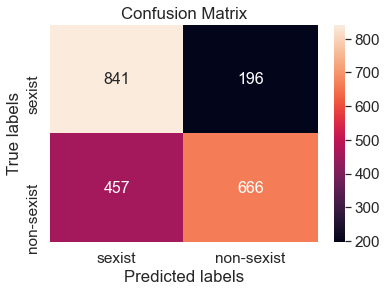

In [164]:

ax = plt.subplot()
df_cm = pd.DataFrame(cm, range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},ax = ax,fmt=".0f")

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['sexist', 'non-sexist']); 
ax.yaxis.set_ticklabels(['sexist', 'non-sexist']);


**Classification report y cálculo del score**

In [165]:
# Estadísticas Relevantes

label=['sexist','non-sexist']
print(classification_report(EXIST2021_test_labeled_data_task1.task1_bin, EXIST2021_test_labeled_data_task1.task1_bin_predicted, target_names=label))

              precision    recall  f1-score   support

      sexist       0.65      0.81      0.72      1037
  non-sexist       0.77      0.59      0.67      1123

    accuracy                           0.70      2160
   macro avg       0.71      0.70      0.70      2160
weighted avg       0.71      0.70      0.69      2160



In [166]:
pipeline.score(EXIST2021_test_labeled_data_task1.Final_text, EXIST2021_test_labeled_data_task1.task1_bin)
  

0.6976851851851852

**Se sigue la misma metodología para para un clasificador LinearSVC con scoring accuracy**

In [66]:

vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True
                )

pipeline = Pipeline([
    ('vect', vectorizer),  
    ('cls', LinearSVC()),
])



parameters = {    
    'vect__max_df': (0.5, 1.9),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'cls__C': (0.2, 0.5, 0.7),
    'cls__loss': ('hinge', 'squared_hinge'),
    'cls__max_iter': (500, 1000)
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1 , scoring='accuracy')
grid_search.fit(EXIST2021_training_data_task1.Final_text, EXIST2021_training_data_task1.task1_bin)

GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x000000000E28D1F8>)),
                                       ('cls', LinearSVC())]),
             n_jobs=-1,
             param_grid={'cls__C': (0.2, 0.5, 0.7),
                         'cls__loss': ('hinge', 'squared_hinge'),
                         'cls__max_iter': (500, 1000),
                         'vect__max_df': (0.5, 1.9),
                         'vect__max_features': (500, 1000),
                         'vect__min_df': (10, 20, 50),
                         'vect__ngram_range': ((1, 1), (1, 2))},
             scoring='accuracy')

In [67]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.7229451045078212
{'cls__C': 0.2, 'cls__loss': 'hinge', 'cls__max_iter': 500, 'vect__max_df': 0.5, 'vect__max_features': 500, 'vect__min_df': 10, 'vect__ngram_range': (1, 2)}
Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=500, min_df=10,
                                 ngram_range=(1, 2),
                                 tokenizer=<function tokenize at 0x000000000E28D1F8>)),
                ('cls', LinearSVC(C=0.2, loss='hinge', max_iter=500))])


In [68]:
model = LinearSVC(C=.2, loss='hinge',max_iter=500,multi_class='ovr',
              random_state=None,
              penalty='l2',
              tol=0.0001
)

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,   
    min_df = 10,
    max_df = 0.5,
    ngram_range=(1, 2),
    max_features=500
)

corpus_data_features = vectorizer.fit_transform(EXIST2021_training_data_task1.Final_text)
corpus_data_features_nd = corpus_data_features.toarray()

In [70]:
scores = cross_val_score(
    model,
    corpus_data_features_nd[0:len(EXIST2021_training_data_task1.Final_text)],
    y=EXIST2021_training_data_task1.task1_bin,
    scoring='accuracy',
    cv=5
    )

scores.mean()

0.7192747802666284

In [71]:
pipeline = Pipeline([
    ('vect', CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,          
            min_df = 10,
            max_df = 0.5,
            ngram_range=(1, 2),
            max_features=500
            )),
    ('cls', LinearSVC(C=.2, loss='hinge',max_iter=500,multi_class='ovr',
             random_state=None,
             penalty='l2',
             tol=0.0001
             )),
])

In [72]:

EXIST2021_test_labeled_data_task1['Final_text'] = text_cleaning(EXIST2021_test_labeled_data_task1)
EXIST2021_test_labeled_data_task1['Final_text'].head()

0                           te golpeo más fuerte perra
1    castigado tres meses sin salir la chica no vie...
2    jajajaj el me he topado con tantos de la onda ...
3    resulta que hoy es el día de la juventud no me...
4    los que dicen que creen en la igualdad pero qu...
Name: Final_text, dtype: object

In [73]:
EXIST2021_test_labeled_data_task1.head()

,id,source,text,task1,task1_bin,Final_text
0,9186,gab,Y te golpeo más fuerte perra.,sexist,1,te golpeo más fuerte perra
1,9187,twitter,@wthxtme @GOLDENMXM Castigado tres meses sin s...,non-sexist,0,castigado tres meses sin salir la chica no vie...
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,sexist,1,jajajaj el me he topado con tantos de la onda ...
3,9189,twitter,Resulta que hoy es el día de la juventud y no ...,non-sexist,0,resulta que hoy es el día de la juventud no me...
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,sexist,1,los que dicen que creen en la igualdad pero qu...


In [74]:
pipeline.fit(EXIST2021_training_data_task1.Final_text,  EXIST2021_training_data_task1.task1_bin)

EXIST2021_test_labeled_data_task1['task1_bin_predicted'] = pipeline.predict(EXIST2021_test_labeled_data_task1.Final_text)


In [76]:
EXIST2021_test_labeled_data_task1.head()

,id,source,text,task1,task1_bin,Final_text,task1_bin_predicted
0,9186,gab,Y te golpeo más fuerte perra.,sexist,1,te golpeo más fuerte perra,0
1,9187,twitter,@wthxtme @GOLDENMXM Castigado tres meses sin s...,non-sexist,0,castigado tres meses sin salir la chica no vie...,0
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,sexist,1,jajajaj el me he topado con tantos de la onda ...,0
3,9189,twitter,Resulta que hoy es el día de la juventud y no ...,non-sexist,0,resulta que hoy es el día de la juventud no me...,0
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,sexist,1,los que dicen que creen en la igualdad pero qu...,1


In [77]:
cm = confusion_matrix(EXIST2021_test_labeled_data_task1.task1_bin,EXIST2021_test_labeled_data_task1.task1_bin_predicted)
print(cm)

[[845 192]
 [428 695]]


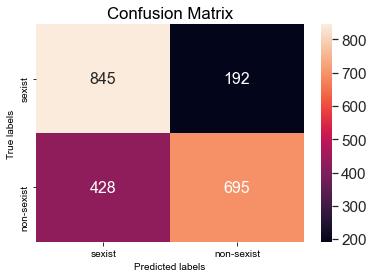

In [78]:
ax = plt.subplot()
df_cm = pd.DataFrame(cm, range(2))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},ax = ax,fmt=".0f")

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['sexist', 'non-sexist']); 
ax.yaxis.set_ticklabels(['sexist', 'non-sexist']);


In [79]:
# Estadísticas Relevantes

label=['sexist','non-sexist']
print(classification_report(EXIST2021_test_labeled_data_task1.task1_bin, EXIST2021_test_labeled_data_task1.task1_bin_predicted, target_names=label))

              precision    recall  f1-score   support

      sexist       0.66      0.81      0.73      1037
  non-sexist       0.78      0.62      0.69      1123

    accuracy                           0.71      2160
   macro avg       0.72      0.72      0.71      2160
weighted avg       0.73      0.71      0.71      2160



In [80]:
pipeline.score(EXIST2021_test_labeled_data_task1.Final_text, EXIST2021_test_labeled_data_task1.task1_bin)
  

0.7129629629629629

**En ambos casos vemos que ambos modelos son sensiblemente más precisos para identificar el sexismo que para identificar el no sexismo**

**EXIST2021-TASK2. CATEGORIZACIÓN DEL SEXISMO. CLASIFICADORES MULTICLASE**

**Selección de datos de training y test categorizados como Sexistas**

In [20]:
EXIST2021_training_data_task2 = EXIST2021_training_data.loc[EXIST2021_training_data['task1']== 'sexist']

EXIST2021_training_data_task2 = EXIST2021_training_data_task2.loc[:,['id','source','text','task2']]

EXIST2021_training_data_task2.head()


,id,source,text,task2
0,3437,twitter,Nadie te va a tratar tan bien como un hombre q...,sexual-violence
1,3438,twitter,"@lindagisela74 Que rica putita obediente, afor...",stereotyping-dominance
7,3444,twitter,"@6Asca @ladycristall Sigues lloriqueando, no m...",misogyny-non-sexual-violence
10,3447,twitter,"Perdonar lo no sólo es posible, es absolutamen...",ideological-inequality
11,3448,twitter,El odio que te tengo nunca se me va a quitar p...,misogyny-non-sexual-violence


In [21]:
EXIST2021_test_labeled_data_task2 = EXIST2021_test_labeled_data.loc[EXIST2021_test_labeled_data['task1']== 'sexist']

EXIST2021_test_labeled_data_task2 = EXIST2021_test_labeled_data_task2.loc[:,['id','source','text','task2']]

EXIST2021_test_labeled_data_task2.head()

,id,source,text,task2
0,9186,gab,Y te golpeo más fuerte perra.,misogyny-non-sexual-violence
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,stereotyping-dominance
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,ideological-inequality
7,9193,twitter,por dios como no podes querer a mis gatas conc...,objectification
10,9196,twitter,Mujer al volante causa terror (Video) - https:...,stereotyping-dominance


**Limpieza de datos de training**

In [22]:
EXIST2021_training_data_task2['Final_text'] = text_cleaning(EXIST2021_training_data_task2)
EXIST2021_training_data_task2['Final_text'].head()



0     nadie te va tratar tan bien como un hombre que...
1     que rica putita obediente afortunado tu marido...
7         sigues lloriqueando no me des la brasa nenaza
10    perdonar lo no sólo es posible es absolutament...
11    el odio que te tengo nunca se me va quitar pin...
Name: Final_text, dtype: object

**Seguimos la misma metodología que para TASK1 pero aplicada a clasificadores multiclase**

**LogisticRegression(),DecisionTreeClassifier() y SVC(). En este caso con scoring f1_macro**

In [ ]:
vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True
                )

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LogisticRegression()),
])



parameters = {
    'vect__max_df': (0.5, 1.9),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'cls__max_iter': (500, 1000),
    'cls__C':(0.1,1, 10, 100),
    'cls__solver'  : ('newton-cg', 'lbfgs', 'liblinear'),
    'cls__penalty' : ('l1','l2')
    
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1 , scoring='f1_macro')
grid_search.fit(EXIST2021_training_data_task2.Final_text, EXIST2021_training_data_task2.task2)

In [24]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.6060976906907178
{'cls__C': 1, 'cls__max_iter': 1000, 'cls__penalty': 'l1', 'cls__solver': 'liblinear', 'vect__max_df': 1.9, 'vect__max_features': 500, 'vect__min_df': 10, 'vect__ngram_range': (1, 1)}
Pipeline(steps=[('vect',
                 CountVectorizer(max_df=1.9, max_features=500, min_df=10,
                                 tokenizer=<function tokenize at 0x0000000006902678>)),
                ('cls',
                 LogisticRegression(C=1, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])


In [26]:
model = LogisticRegression(C=1.0,max_iter=1000,random_state=None,solver = 'liblinear',penalty='l1',multi_class = 'ovr')


vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,   
    min_df = 10,
    max_df = 1.9,
    ngram_range=(1, 1),
    max_features=500
)

corpus_data_features = vectorizer.fit_transform(EXIST2021_training_data_task2.Final_text)
corpus_data_features_nd = corpus_data_features.toarray()

In [28]:
scores = cross_val_score(
    model,
    corpus_data_features_nd[0:len(EXIST2021_training_data_task2)],
    y=EXIST2021_training_data_task2.task2,
    scoring='f1_macro',
    cv=10
    )

scores.mean()

0.6143156385931396

In [29]:
pipeline = Pipeline([
    ('vect', CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,          
            min_df = 10,
            max_df = 1.9,
            ngram_range=(1, 1),
            max_features=500
            )),
    ('cls', LogisticRegression(C=1,max_iter=1000,solver = 'liblinear',multi_class='ovr',
             random_state=None,
             penalty='l1'             
             )),
])

In [30]:

EXIST2021_test_labeled_data_task2['Final_text'] = text_cleaning(EXIST2021_test_labeled_data_task2)
EXIST2021_test_labeled_data_task2['Final_text'].head()

0                            te golpeo más fuerte perra
2     jajajaj el me he topado con tantos de la onda ...
4     los que dicen que creen en la igualdad pero qu...
7     por dios como no podes querer mis gatas concha...
10                  mujer al volante causa terror video
Name: Final_text, dtype: object

In [31]:
EXIST2021_test_labeled_data_task2.head()

,id,source,text,task2,Final_text
0,9186,gab,Y te golpeo más fuerte perra.,misogyny-non-sexual-violence,te golpeo más fuerte perra
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,stereotyping-dominance,jajajaj el me he topado con tantos de la onda ...
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,ideological-inequality,los que dicen que creen en la igualdad pero qu...
7,9193,twitter,por dios como no podes querer a mis gatas conc...,objectification,por dios como no podes querer mis gatas concha...
10,9196,twitter,Mujer al volante causa terror (Video) - https:...,stereotyping-dominance,mujer al volante causa terror video


In [32]:
pipeline.fit(EXIST2021_training_data_task2.Final_text,  EXIST2021_training_data_task2.task2)


EXIST2021_test_labeled_data_task2['task2_predicted'] = pipeline.predict(EXIST2021_test_labeled_data_task2.Final_text)

In [33]:
EXIST2021_test_labeled_data_task2.head()

,id,source,text,task2,Final_text,task2_predicted
0,9186,gab,Y te golpeo más fuerte perra.,misogyny-non-sexual-violence,te golpeo más fuerte perra,misogyny-non-sexual-violence
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,stereotyping-dominance,jajajaj el me he topado con tantos de la onda ...,ideological-inequality
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,ideological-inequality,los que dicen que creen en la igualdad pero qu...,ideological-inequality
7,9193,twitter,por dios como no podes querer a mis gatas conc...,objectification,por dios como no podes querer mis gatas concha...,misogyny-non-sexual-violence
10,9196,twitter,Mujer al volante causa terror (Video) - https:...,stereotyping-dominance,mujer al volante causa terror video,stereotyping-dominance


In [34]:
 print('Accuracy:',pipeline.score(EXIST2021_test_labeled_data_task2.Final_text, EXIST2021_test_labeled_data_task2.task2))

Accuracy: 0.6242208370436332


In [35]:
print('F1-score:',f1_score(EXIST2021_test_labeled_data_task2.task2,EXIST2021_test_labeled_data_task2['task2_predicted'],average="macro"))

F1-score: 0.6172915011455483


In [37]:
print(classification_report(EXIST2021_test_labeled_data_task2.task2,EXIST2021_test_labeled_data_task2['task2_predicted']))

                              precision    recall  f1-score   support

      ideological-inequality       0.68      0.76      0.72       288
misogyny-non-sexual-violence       0.55      0.61      0.58       257
             objectification       0.61      0.48      0.54       174
             sexual-violence       0.86      0.59      0.70       202
      stereotyping-dominance       0.51      0.60      0.55       202

                    accuracy                           0.62      1123
                   macro avg       0.64      0.61      0.62      1123
                weighted avg       0.64      0.62      0.63      1123



In [39]:
cm = confusion_matrix(EXIST2021_test_labeled_data_task2.task2,EXIST2021_test_labeled_data_task2['task2_predicted'])
print(cm)

[[219  30   4   4  31]
 [ 41 158  16   6  36]
 [ 12  37  83   8  34]
 [ 14  38  15 120  15]
 [ 35  26  18   2 121]]


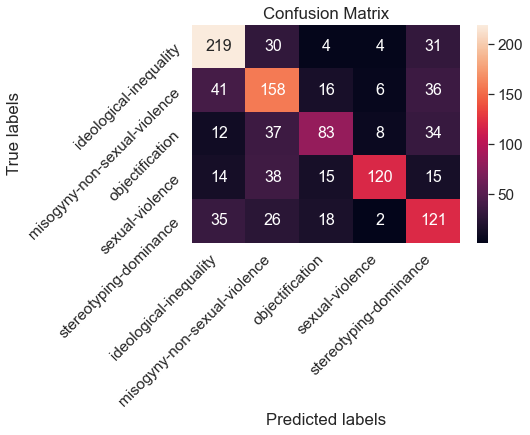

In [43]:

ax = plt.subplot()
df_cm = pd.DataFrame(cm, range(5))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},ax = ax,fmt=".0f")


# labels, title and ticks
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, ha="right")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['ideological-inequality', 'misogyny-non-sexual-violence','objectification','sexual-violence','stereotyping-dominance']); 
ax.yaxis.set_ticklabels(['ideological-inequality', 'misogyny-non-sexual-violence','objectification','sexual-violence','stereotyping-dominance']);


In [ ]:
vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True
                )

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', DecisionTreeClassifier()),
])



parameters = {
    'vect__max_df': (0.5, 1.9),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'cls__criterion':('gini', 'entropy', 'log_loss'),
    'cls__max_depth':(2,4,6,8,10,12)
  
    
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1 , scoring='f1_macro')
grid_search.fit(EXIST2021_training_data_task2.Final_text, EXIST2021_training_data_task2.task2)

In [45]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.5103599337327697
{'cls__criterion': 'gini', 'cls__max_depth': 12, 'vect__max_df': 0.5, 'vect__max_features': 500, 'vect__min_df': 10, 'vect__ngram_range': (1, 1)}
Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=500, min_df=10,
                                 tokenizer=<function tokenize at 0x0000000006902678>)),
                ('cls', DecisionTreeClassifier(max_depth=12))])


In [47]:
model = DecisionTreeClassifier(criterion='gini',max_depth=12,random_state=None)


vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,   
    min_df = 10,
    max_df = 0.5,
    ngram_range=(1, 1),
    max_features=500
)

corpus_data_features = vectorizer.fit_transform(EXIST2021_training_data_task2.Final_text)
corpus_data_features_nd = corpus_data_features.toarray()

In [48]:
scores = cross_val_score(
    model,
    corpus_data_features_nd[0:len(EXIST2021_training_data_task2)],
    y=EXIST2021_training_data_task2.task2,
    scoring='f1_macro',
    cv=10
    )

scores.mean()

0.5171088452820842

In [49]:
pipeline = Pipeline([
    ('vect', CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,          
            min_df = 10,
            max_df = 0.5,
            ngram_range=(1, 1),
            max_features=500
            )),
    ('cls', DecisionTreeClassifier(criterion='gini',max_depth=12,
             random_state=None                         
             )),
])

In [50]:
pipeline.fit(EXIST2021_training_data_task2.Final_text,  EXIST2021_training_data_task2.task2)


EXIST2021_test_labeled_data_task2['task2_predicted'] = pipeline.predict(EXIST2021_test_labeled_data_task2.Final_text)

In [52]:
EXIST2021_test_labeled_data_task2.head()

,id,source,text,task2,Final_text,task2_predicted
0,9186,gab,Y te golpeo más fuerte perra.,misogyny-non-sexual-violence,te golpeo más fuerte perra,misogyny-non-sexual-violence
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,stereotyping-dominance,jajajaj el me he topado con tantos de la onda ...,misogyny-non-sexual-violence
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,ideological-inequality,los que dicen que creen en la igualdad pero qu...,ideological-inequality
7,9193,twitter,por dios como no podes querer a mis gatas conc...,objectification,por dios como no podes querer mis gatas concha...,misogyny-non-sexual-violence
10,9196,twitter,Mujer al volante causa terror (Video) - https:...,stereotyping-dominance,mujer al volante causa terror video,stereotyping-dominance


In [53]:
 print('Accuracy:',pipeline.score(EXIST2021_test_labeled_data_task2.Final_text, EXIST2021_test_labeled_data_task2.task2))

Accuracy: 0.5084594835262689


In [54]:
print('F1-score:',f1_score(EXIST2021_test_labeled_data_task2.task2,EXIST2021_test_labeled_data_task2['task2_predicted'],average="macro"))

F1-score: 0.49155387341454926


In [55]:
print(classification_report(EXIST2021_test_labeled_data_task2.task2,EXIST2021_test_labeled_data_task2['task2_predicted']))

                              precision    recall  f1-score   support

      ideological-inequality       0.76      0.55      0.64       288
misogyny-non-sexual-violence       0.34      0.81      0.48       257
             objectification       0.70      0.18      0.29       174
             sexual-violence       0.86      0.48      0.61       202
      stereotyping-dominance       0.51      0.38      0.44       202

                    accuracy                           0.51      1123
                   macro avg       0.63      0.48      0.49      1123
                weighted avg       0.63      0.51      0.51      1123



In [56]:
cm = confusion_matrix(EXIST2021_test_labeled_data_task2.task2,EXIST2021_test_labeled_data_task2['task2_predicted'])
print(cm)

[[158 106   0   6  18]
 [ 18 208   6   2  23]
 [  6 111  32   6  19]
 [ 22  65   4  96  15]
 [  5 115   4   1  77]]


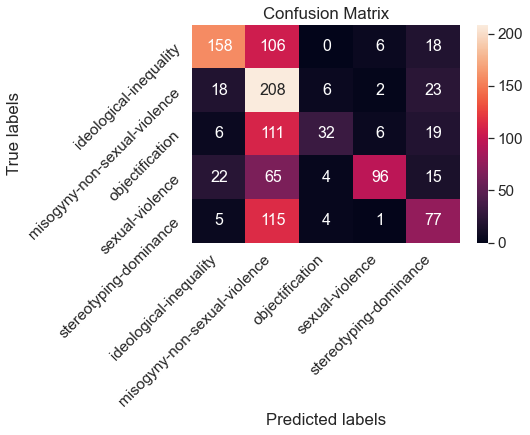

In [57]:
ax = plt.subplot()
df_cm = pd.DataFrame(cm, range(5))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},ax = ax,fmt=".0f")


# labels, title and ticks
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, ha="right")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['ideological-inequality', 'misogyny-non-sexual-violence','objectification','sexual-violence','stereotyping-dominance']); 
ax.yaxis.set_ticklabels(['ideological-inequality', 'misogyny-non-sexual-violence','objectification','sexual-violence','stereotyping-dominance']);


In [ ]:
grid_search.cv_results_ 

In [58]:
vectorizer = CountVectorizer(
                analyzer = 'word',
                tokenizer = tokenize,
                lowercase = True
                )

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', SVC()),
])



parameters = {
    'vect__max_df': (0.5, 1.9),
    'vect__min_df': (10, 20,50),
    'vect__max_features': (500, 1000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'cls__kernel':('linear','poly','rbf','sigmoid'),
    'cls__gamma': (1,0.1,0.01,0.001),
    'cls__max_iter': (500, 1000),
    'cls__C':(0.1,1, 10, 100),
    
}


grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1 , scoring='f1_macro')
grid_search.fit(EXIST2021_training_data_task2.Final_text, EXIST2021_training_data_task2.task2)

C:\ProgramData\Anaconda3\envs\pec11\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(estimator=Pipeline(steps=[('vect',
                                        CountVectorizer(tokenizer=<function tokenize at 0x0000000006902678>)),
                                       ('cls', SVC())]),
             n_jobs=-1,
             param_grid={'cls__C': (0.1, 1, 10, 100),
                         'cls__gamma': (1, 0.1, 0.01, 0.001),
                         'cls__kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
                         'cls__max_iter': (500, 1000),
                         'vect__max_df': (0.5, 1.9),
                         'vect__max_features': (500, 1000),
                         'vect__min_df': (10, 20, 50),
                         'vect__ngram_range': ((1, 1), (1, 2))},
             scoring='f1_macro')

In [59]:
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

0.5947005567955699
{'cls__C': 10, 'cls__gamma': 0.01, 'cls__kernel': 'rbf', 'cls__max_iter': 1000, 'vect__max_df': 0.5, 'vect__max_features': 500, 'vect__min_df': 10, 'vect__ngram_range': (1, 2)}
Pipeline(steps=[('vect',
                 CountVectorizer(max_df=0.5, max_features=500, min_df=10,
                                 ngram_range=(1, 2),
                                 tokenizer=<function tokenize at 0x0000000006902678>)),
                ('cls', SVC(C=10, gamma=0.01, max_iter=1000))])


In [60]:
model = SVC(C=10,max_iter=1000,gamma=0.01,kernel='rbf',random_state=None,tol=0.0001)

vectorizer = CountVectorizer(
    analyzer = 'word',
    tokenizer = tokenize,
    lowercase = True,   
    min_df = 10,
    max_df = 0.5,
    ngram_range=(1, 2),
    max_features=500
)

corpus_data_features = vectorizer.fit_transform(EXIST2021_training_data_task2.Final_text)
corpus_data_features_nd = corpus_data_features.toarray()

In [61]:
scores = cross_val_score(
    model,
    corpus_data_features_nd[0:len(EXIST2021_training_data_task2)],
    y=EXIST2021_training_data_task2.task2,
    scoring='f1_macro',
    cv=10
    )

scores.mean()

C:\ProgramData\Anaconda3\envs\pec11\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\pec11\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\pec11\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\envs\pec11\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceW

0.6135120767585704

In [62]:
pipeline = Pipeline([
    ('vect', CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,          
            min_df = 10,
            max_df = 0.5,
            ngram_range=(1, 2),
            max_features=500
            )),
    ('cls', SVC(C=10,max_iter=1000,gamma=0.01,kernel='rbf',random_state=None,tol=0.0001)),
])

In [63]:
pipeline.fit(EXIST2021_training_data_task2.Final_text,  EXIST2021_training_data_task2.task2)


EXIST2021_test_labeled_data_task2['task2_predicted'] = pipeline.predict(EXIST2021_test_labeled_data_task2.Final_text)

C:\ProgramData\Anaconda3\envs\pec11\lib\site-packages\sklearn\svm\_base.py:258: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [64]:
EXIST2021_test_labeled_data_task2.head()

,id,source,text,task2,Final_text,task2_predicted
0,9186,gab,Y te golpeo más fuerte perra.,misogyny-non-sexual-violence,te golpeo más fuerte perra,misogyny-non-sexual-violence
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,stereotyping-dominance,jajajaj el me he topado con tantos de la onda ...,ideological-inequality
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,ideological-inequality,los que dicen que creen en la igualdad pero qu...,ideological-inequality
7,9193,twitter,por dios como no podes querer a mis gatas conc...,objectification,por dios como no podes querer mis gatas concha...,misogyny-non-sexual-violence
10,9196,twitter,Mujer al volante causa terror (Video) - https:...,stereotyping-dominance,mujer al volante causa terror video,stereotyping-dominance


In [65]:
 print('Accuracy:',pipeline.score(EXIST2021_test_labeled_data_task2.Final_text, EXIST2021_test_labeled_data_task2.task2))

Accuracy: 0.5966162065894924


In [66]:
print('F1-score:',f1_score(EXIST2021_test_labeled_data_task2.task2,EXIST2021_test_labeled_data_task2['task2_predicted'],average="macro"))

F1-score: 0.5864125725971073


In [67]:
print(classification_report(EXIST2021_test_labeled_data_task2.task2,EXIST2021_test_labeled_data_task2['task2_predicted']))

                              precision    recall  f1-score   support

      ideological-inequality       0.68      0.74      0.71       288
misogyny-non-sexual-violence       0.50      0.60      0.55       257
             objectification       0.59      0.40      0.47       174
             sexual-violence       0.84      0.54      0.66       202
      stereotyping-dominance       0.49      0.61      0.55       202

                    accuracy                           0.60      1123
                   macro avg       0.62      0.58      0.59      1123
                weighted avg       0.62      0.60      0.60      1123



In [68]:
cm = confusion_matrix(EXIST2021_test_labeled_data_task2.task2,EXIST2021_test_labeled_data_task2['task2_predicted'])
print(cm)

[[213  34   1   8  32]
 [ 39 155  13   4  46]
 [ 15  51  69   6  33]
 [ 18  39  18 109  18]
 [ 30  30  16   2 124]]


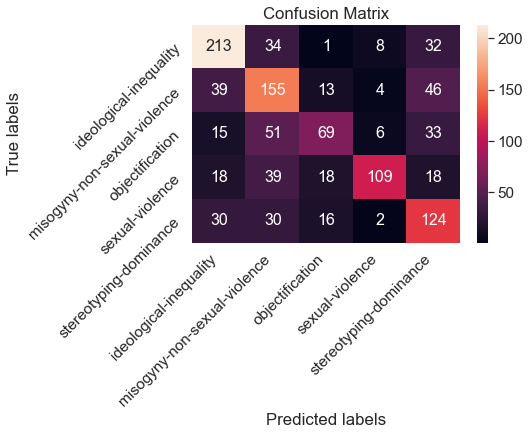

In [69]:
ax = plt.subplot()
df_cm = pd.DataFrame(cm, range(5))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16},ax = ax,fmt=".0f")


# labels, title and ticks
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=45, ha="right")
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['ideological-inequality', 'misogyny-non-sexual-violence','objectification','sexual-violence','stereotyping-dominance']); 
ax.yaxis.set_ticklabels(['ideological-inequality', 'misogyny-non-sexual-violence','objectification','sexual-violence','stereotyping-dominance']);


**Comentar que, en relación al ranking de EXISTS2021, nos hemos aproximado bastante al accuracy en TASK1 y hemos conseguido mejores resultados en el caso del F1 score para TASK2**

**Indicar también que de forma general para TASK2, vemos que la categoría más problemática para identificar es la objetización y las menos problemáticas la misoginia sin violencia sexual y la ideológica-desigualdad**

# 2.  Topic Modelling con LDA


**Lectura y concatenación de ficheros de training y test**

In [2]:
EXIST2021_training_data =  pd.read_csv('EXIST2021_training_es.csv',sep=';')
EXIST2021_training_data.head()


,id,source,text,task1,task2
0,3437,twitter,Nadie te va a tratar tan bien como un hombre q...,sexist,sexual-violence
1,3438,twitter,"@lindagisela74 Que rica putita obediente, afor...",sexist,stereotyping-dominance
2,3439,twitter,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist,non-sexist
3,3440,twitter,las cosas q sueño son indicios de que yo enrea...,non-sexist,non-sexist
4,3441,twitter,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist,non-sexist


In [3]:
EXIST2021_test_labeled_data =  pd.read_csv('EXIST2021_test_labeled_es.csv',sep=';')
EXIST2021_test_labeled_data.head()

,id,source,text,task1,task2
0,9186,gab,Y te golpeo más fuerte perra.,sexist,misogyny-non-sexual-violence
1,9187,twitter,@wthxtme @GOLDENMXM Castigado tres meses sin s...,non-sexist,non-sexist
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,sexist,stereotyping-dominance
3,9189,twitter,Resulta que hoy es el día de la juventud y no ...,non-sexist,non-sexist
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,sexist,ideological-inequality


In [4]:
EXIST2021_training_data_task1 = EXIST2021_training_data.iloc[:,0:4]
EXIST2021_training_data_task1.head()

,id,source,text,task1
0,3437,twitter,Nadie te va a tratar tan bien como un hombre q...,sexist
1,3438,twitter,"@lindagisela74 Que rica putita obediente, afor...",sexist
2,3439,twitter,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,3440,twitter,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,3441,twitter,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [5]:
EXIST2021_test_labeled_data_task1 = EXIST2021_test_labeled_data.iloc[:,0:4]
EXIST2021_test_labeled_data_task1.head()


,id,source,text,task1
0,9186,gab,Y te golpeo más fuerte perra.,sexist
1,9187,twitter,@wthxtme @GOLDENMXM Castigado tres meses sin s...,non-sexist
2,9188,twitter,@MaricaIndomito jajajaj el me he topado con ta...,sexist
3,9189,twitter,Resulta que hoy es el día de la juventud y no ...,non-sexist
4,9190,twitter,@EstefMolina_ Los que dicen que creen en la ig...,sexist


In [6]:
EXIST2021_all_text = pd.DataFrame()
EXIST2021_all_text = pd.concat([EXIST2021_training_data_task1,EXIST2021_test_labeled_data_task1],ignore_index=True)
EXIST2021_all_text.head()

,id,source,text,task1
0,3437,twitter,Nadie te va a tratar tan bien como un hombre q...,sexist
1,3438,twitter,"@lindagisela74 Que rica putita obediente, afor...",sexist
2,3439,twitter,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist
3,3440,twitter,las cosas q sueño son indicios de que yo enrea...,non-sexist
4,3441,twitter,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist


In [7]:
# Functions the mentioned text cleaning steps
def lowercase_text(sentence):
    return sentence.lower()

def remove_usernames(sentence):
    sentence = re.sub(r'@\w+',' ', sentence)
    return sentence

def remove_hashtags(sentence):
    sentence = re.sub(r"#\w+",' ', sentence)
    return sentence

def remove_links(sentence):
    sentence = re.sub(r'\bhttps?://[^\s]*',' ', sentence)
    return sentence

def remove_numbers(sentence):
    sentence = re.sub(r'\d+',' ', sentence)
    return sentence

def remove_punctuation_and_spaces(sentence):
    sentence = re.sub(r'&', ' ', sentence) # Specific for &
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    sentence = ' '.join(sentence.split())
    return sentence

def remove_1letter_words(sentence):
    sentence = re.sub(r'\b\w{1}\b', ' ', sentence)
    return sentence

def tokenize_clean(sentence):
    list_of_words = sentence.split(" ")
    return list_of_words

In [8]:
# Function to apply all text tranformations
def text_cleaning(df):
   
    lists_of_text = []

    for text in df['text']:
        sentence = str(text)

        # Text transformations
        sentence = lowercase_text(sentence) # All in lowercase
        sentence = remove_links(sentence) # Remove links
        sentence = remove_hashtags(sentence) # Remove Hashtags
        sentence = remove_usernames(sentence) # Remove usernames
        sentence = remove_numbers(sentence) # Remove numbers
        sentence = remove_punctuation_and_spaces(sentence) # Remove punctuation signs and multiple spaces
        sentence = remove_1letter_words(sentence) # Remove words with len=1
        sentence = remove_punctuation_and_spaces(sentence)
        
        list_of_words = tokenize_clean(sentence) # Tokenization     
        
        # Converting list of words to text again
        lists_of_text.append(' '.join(list_of_words))

    return lists_of_text

**Limpieza del texto**

In [9]:
EXIST2021_all_text['Final_text'] = text_cleaning(EXIST2021_all_text)
EXIST2021_all_text['Final_text'].head()

0    nadie te va tratar tan bien como un hombre que...
1    que rica putita obediente afortunado tu marido...
2    yo lo hice los años por la carretera libre ver...
3    las cosas sueño son indicios de que yo enreali...
4    pero la niña le gustó desde que lo vió así que...
Name: Final_text, dtype: object

**Tokenización**

In [10]:
tokenizer = ToktokTokenizer() 

EXIST2021_all_text['Tokens'] = EXIST2021_all_text.Final_text.apply(tokenizer.tokenize)
EXIST2021_all_text.head()

,id,source,text,task1,Final_text,Tokens
0,3437,twitter,Nadie te va a tratar tan bien como un hombre q...,sexist,nadie te va tratar tan bien como un hombre que...,"[nadie, te, va, tratar, tan, bien, como, un, h..."
1,3438,twitter,"@lindagisela74 Que rica putita obediente, afor...",sexist,que rica putita obediente afortunado tu marido...,"[que, rica, putita, obediente, afortunado, tu,..."
2,3439,twitter,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist,yo lo hice los años por la carretera libre ver...,"[yo, lo, hice, los, años, por, la, carretera, ..."
3,3440,twitter,las cosas q sueño son indicios de que yo enrea...,non-sexist,las cosas sueño son indicios de que yo enreali...,"[las, cosas, sueño, son, indicios, de, que, yo..."
4,3441,twitter,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist,pero la niña le gustó desde que lo vió así que...,"[pero, la, niña, le, gustó, desde, que, lo, vi..."


**Filtrado de stopwords y dígitos**

In [11]:
STOPWORDS = set(stopwords.words("spanish"))

def filtrar_stopword_digitos(tokens):
    """
    Filtra stopwords y digitos de una lista de tokens.
    """
    return [token for token in tokens if token not in STOPWORDS 
            and not token.isdigit()]



In [12]:
EXIST2021_all_text["Tokens"] = EXIST2021_all_text.Tokens.apply(filtrar_stopword_digitos)
EXIST2021_all_text.head()

,id,source,text,task1,Final_text,Tokens
0,3437,twitter,Nadie te va a tratar tan bien como un hombre q...,sexist,nadie te va tratar tan bien como un hombre que...,"[nadie, va, tratar, tan, bien, hombre, quiere,..."
1,3438,twitter,"@lindagisela74 Que rica putita obediente, afor...",sexist,que rica putita obediente afortunado tu marido...,"[rica, putita, obediente, afortunado, marido, ..."
2,3439,twitter,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist,yo lo hice los años por la carretera libre ver...,"[hice, años, carretera, libre, veracruz, ahora..."
3,3440,twitter,las cosas q sueño son indicios de que yo enrea...,non-sexist,las cosas sueño son indicios de que yo enreali...,"[cosas, sueño, indicios, enrealidad, lesbiana,..."
4,3441,twitter,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist,pero la niña le gustó desde que lo vió así que...,"[niña, gustó, vió, así, dije, hola, bien, día,..."


**Proceso de stemming: Reducción de cada palabra a su raíz**

**Se utiliza el algoritmo de Porter incluído en la librería NLTK**

In [13]:
stemmer = SnowballStemmer("spanish")

def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]



In [14]:
EXIST2021_all_text["Stemmed"] = EXIST2021_all_text.Tokens.apply(stem_palabras)

EXIST2021_all_text.head()

,id,source,text,task1,Final_text,Tokens,Stemmed
0,3437,twitter,Nadie te va a tratar tan bien como un hombre q...,sexist,nadie te va tratar tan bien como un hombre que...,"[nadie, va, tratar, tan, bien, hombre, quiere,...","[nadi, va, trat, tan, bien, hombr, quier, met,..."
1,3438,twitter,"@lindagisela74 Que rica putita obediente, afor...",sexist,que rica putita obediente afortunado tu marido...,"[rica, putita, obediente, afortunado, marido, ...","[ric, putit, obedient, afortun, mar, ten, muj,..."
2,3439,twitter,@BicireporteraDF Yo lo hice a los 18 años por ...,non-sexist,yo lo hice los años por la carretera libre ver...,"[hice, años, carretera, libre, veracruz, ahora...","[hic, años, carreter, libr, veracruz, ahor, ca..."
3,3440,twitter,las cosas q sueño son indicios de que yo enrea...,non-sexist,las cosas sueño son indicios de que yo enreali...,"[cosas, sueño, indicios, enrealidad, lesbiana,...","[cos, sueñ, indici, enreal, lesbian, reprim, n..."
4,3441,twitter,"Pero a la niña le gustó desde que lo vió, así ...",non-sexist,pero la niña le gustó desde que lo vió así que...,"[niña, gustó, vió, así, dije, hola, bien, día,...","[niñ, gust, vio, asi, dij, hol, bien, dia, sol..."


**Generación del diccionario (Gensim)**

In [15]:
diccionario = Dictionary(EXIST2021_all_text.Stemmed)
print(f'Número de tokens: {len(diccionario)}')

Número de tokens: 11142


**Inicialización del corpus: Cada documento se transforma en una bolsa de palabras BOW con las frecuencias de aparición**

In [16]:
# Creamos el corpus 
corpus = [diccionario.doc2bow(tweet) for tweet in EXIST2021_all_text.Stemmed]

# Mostramos el BOW de un tweet
print(corpus[6])

[(2, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 2), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1)]


**Construcción del modelo LDA**

In [17]:
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=50, random_state=42, 
               chunksize=1000, passes=10, alpha='auto')

**Visualización de tópicos. Nube de palabras (WordCloud)**

In [18]:
topicos = lda.print_topics(num_words=5, num_topics=20)
for topico in topicos:
    print(topico)

(47, '0.089*"aunqu" + 0.072*"nenaz" + 0.044*"total" + 0.044*"acept" + 0.035*"particip"')
(30, '0.124*"tip" + 0.063*"manspreading" + 0.061*"vas" + 0.044*"ultim" + 0.037*"drog"')
(3, '0.113*"cort" + 0.070*"fald" + 0.053*"frent" + 0.050*"larg" + 0.031*"ment"')
(40, '0.121*"violacion" + 0.072*"fot" + 0.049*"conden" + 0.040*"segun" + 0.034*"nacional"')
(14, '0.128*"nuev" + 0.120*"llev" + 0.095*"man" + 0.078*"mam" + 0.042*"quien"')
(19, '0.059*"parej" + 0.055*"final" + 0.041*"inclus" + 0.031*"año" + 0.030*"san"')
(34, '0.048*"consider" + 0.044*"vien" + 0.034*"gobiern" + 0.027*"trump" + 0.027*"pedaz"')
(32, '0.079*"vist" + 0.072*"car" + 0.043*"pag" + 0.035*"sirv" + 0.033*"ojal"')
(49, '0.097*"clar" + 0.072*"vec" + 0.036*"violador" + 0.034*"poc" + 0.029*"dond"')
(17, '0.106*"abort" + 0.092*"public" + 0.049*"dar" + 0.040*"mor" + 0.034*"celebr"')
(37, '0.126*"tan" + 0.119*"bien" + 0.066*"mund" + 0.045*"hombr" + 0.040*"conoc"')
(39, '0.117*"dia" + 0.091*"mujer" + 0.080*"hoy" + 0.039*"pod" + 0.035

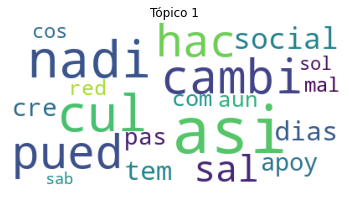

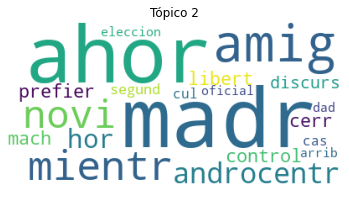

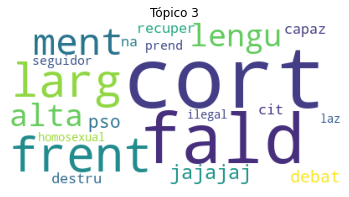

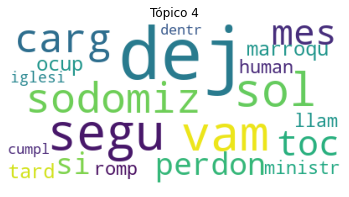

In [19]:
for i in range(1, 5):
    plt.figure()
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0)
               .fit_words(dict(lda.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
    plt.show()

**Evaluación del modelo con una tweet del conjunto**

In [43]:
indice_tweet = random.randint(0,len(EXIST2021_all_text))
tweet = EXIST2021_all_text.iloc[indice_tweet]
print("Tweet: " + tweet.Final_text)


Tweet: hasta una feminazi se va dejar maltratar por un hombre la hora de coger porque cuando una mujer anda con ganas de que le metan la verga se olvida de cualquier ideal principio hasta que se le baje la calentura


**Representación BOW y distribución de tópicos del documento**

In [44]:
bow_tweet = corpus[indice_tweet]
distribucion_tweet = lda[bow_tweet]

print(bow_tweet)
print(distribucion_tweet)

[(1, 1), (2, 1), (8, 1), (12, 1), (165, 1), (201, 1), (233, 1), (356, 1), (603, 1), (708, 1), (818, 1), (879, 1), (1146, 1), (1194, 1), (1296, 1), (1655, 1), (1802, 1), (2710, 1)]
[(2, 0.0509694), (4, 0.0379818), (11, 0.05833467), (22, 0.051842775), (24, 0.05105242), (25, 0.11538702), (26, 0.09862312), (29, 0.052431647), (32, 0.050195925), (33, 0.061706264), (37, 0.07299206), (38, 0.050780836), (41, 0.10672502), (44, 0.051318105)]


**Indices y contribución de los tópicos más significativos**

In [45]:
# Indices de los topicos mas significativos
dist_indices = [topico[0] for topico in lda[bow_tweet]]
# Contribución de los topicos mas significativos
dist_contrib = [topico[1] for topico in lda[bow_tweet]]

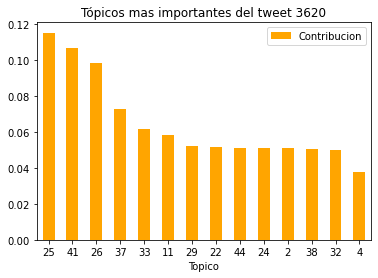

In [46]:
distribucion_topicos = pd.DataFrame({'Topico':dist_indices,
                                     'Contribucion':dist_contrib })
distribucion_topicos.sort_values('Contribucion', 
                                 ascending=False, inplace=True)
ax = distribucion_topicos.plot.bar(y='Contribucion',x='Topico', 
                                   rot=0, color="orange",
                                   title = 'Tópicos mas importantes del tweet ' + str(indice_tweet))

In [47]:
for ind, topico in distribucion_topicos.iterrows():
    print("*** Tópico: " + str(int(topico.Topico)) + " ***")
    palabras = [palabra[0] for palabra in lda.show_topic(
        topicid=int(topico.Topico))]
    palabras = ', '.join(palabras)
    print(palabras, "\n")

*** Tópico: 25 ***
muj, ser, gan, quier, florer, hombr, diner, rebeld, pas, mar 

*** Tópico: 41 ***
dic, habl, si, pues, embaraz, ser, hac, pued, feminazi, señorit 

*** Tópico: 26 ***
hech, denunci, met, intent, baj, vari, ello, mir, top, articul 

*** Tópico: 37 ***
tan, bien, mund, hombr, conoc, sient, peor, moment, sufr, ser 

*** Tópico: 33 ***
chic, mas, cos, hac, ser, tont, esper, masculin, rubi, veo 

*** Tópico: 11 ***
cuent, mierd, tir, cag, padr, si, vez, relacion, hab, entonc 

*** Tópico: 29 ***
buen, va, tet, not, gord, siempr, niñat, perd, encant, llor 

*** Tópico: 22 ***
put, hij, parec, respet, hermos, hiz, salg, mil, sep, increibl 

*** Tópico: 44 ***
quier, peg, mujer, rob, carcel, respons, pequeñ, recuerd, real, maltrat 

*** Tópico: 24 ***
ningun, vide, comentari, izquierd, inform, olvid, deten, via, compart, radical 

*** Tópico: 2 ***
madr, ahor, amig, mientr, novi, androcentr, hor, prefier, libert, mach 

*** Tópico: 38 ***
tom, comun, sex, famili, sos, si, de

**Evaluación del modelo con un tweet nuevo**

In [48]:
texto_tweet =pd.DataFrame()
texto_tweet['text'] =  ['@test. Una feminazi maltratada por un hombre olvida ideales si quiere que se la metan']
texto_tweet


,text
0,@test. Una feminazi maltratada por un hombre o...


**Preprocesamos el tweet al igual que hicimos con el corpus y después realizamos las estimaciones**

In [49]:

texto_tweet_c = text_cleaning(texto_tweet)

chars = ['[', ']', "''"]
 
texto_tweet_c = texto_tweet_c[0].translate(str.maketrans('', '', ''.join(chars)))
texto_tweet_c
   
texto_tweet_t = tokenizer.tokenize(texto_tweet_c)
texto_tweet_t
texto_tweet_sw = filtrar_stopword_digitos(texto_tweet_t)
texto_tweet_sw
texto_tweet_st = stem_palabras(texto_tweet_sw)
texto_tweet_st

['feminazi', 'maltrat', 'hombr', 'olvid', 'ideal', 'si', 'quier', 'met']

In [50]:
bow_tweet_nuevo = diccionario.doc2bow(texto_tweet_st)
print(bow_tweet_nuevo)

[(1, 1), (2, 1), (5, 1), (24, 1), (233, 1), (356, 1), (1194, 1), (1802, 1)]


In [51]:
# Indices de los topicos mas significativos
dist_indices_new = [topico[0] for topico in lda[bow_tweet_nuevo]]
# Contribucion de los topicos mas significativos
dist_contrib_new = [topico[1] for topico in lda[bow_tweet_nuevo]]

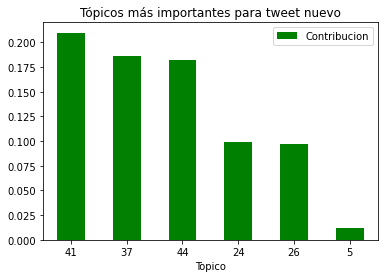

In [52]:
distribucion_topicos_new = pd.DataFrame({'Topico':dist_indices_new,
                                     'Contribucion':dist_contrib_new })
distribucion_topicos_new.sort_values('Contribucion', 
                                 ascending=False, inplace=True)
ax = distribucion_topicos_new.plot.bar(y='Contribucion',x='Topico', 
                                   rot=0, color="green",
                                   title = 'Tópicos más importantes para tweet nuevo')

In [53]:
for ind, topico in distribucion_topicos_new.iterrows():
    print("*** Tópico: " + str(int(topico.Topico)) + " ***")
    palabras = [palabra[0] for palabra in lda.show_topic(
        topicid=int(topico.Topico))]
    palabras = ', '.join(palabras)
    print(palabras, "\n")

*** Tópico: 41 ***
dic, habl, si, pues, embaraz, ser, hac, pued, feminazi, señorit 

*** Tópico: 37 ***
tan, bien, mund, hombr, conoc, sient, peor, moment, sufr, ser 

*** Tópico: 44 ***
quier, peg, mujer, rob, carcel, respons, pequeñ, recuerd, real, maltrat 

*** Tópico: 24 ***
ningun, vide, comentari, izquierd, inform, olvid, deten, via, compart, radical 

*** Tópico: 26 ***
hech, denunci, met, intent, baj, vari, ello, mir, top, articul 

*** Tópico: 5 ***
femin, mujer, hac, hombr, derech, gener, odi, dañ, iguald, luch 



**Como vemos, los tópicos más relevantes del tweet analizado son el 41, el 37 y el 44. En ellos podemos ver que aparecen los términos feminazi, hombre**

**Vemos que es posible también utilizar esta técnica de detección de tópicos para detectar sexismo y trazas de violencia de género en las publicaciones en redes sociales**

**SIMILITUD ENTRE TEXTOS**

**Primero obtenemos la distribución de tópicos del texto nuevo del cual queremos obtener los textos más similares. Después,  calculamos la distancia entre ese texto nuevo y el resto comparando sus distribuciones de tópicos.**

**Para calcular la distancia entre dos distribuciones utilizaremos la métrica de distancia de Jensen-Shannon, una medida de distancia estadística entre distribuciones de probabilidad. Esta métrica nos devolverá un valor comprendido entre 0 y 1, donde cuanto menor sea este valor significa una mayor similitud entre las dos distribuciones.**

In [54]:
from gensim.matutils import jensen_shannon

In [55]:
texto_tweet =pd.DataFrame()
texto_tweet['text'] =  ['@test. Todas las feminazis son iguales. Se olvidan pronto de los ideales si conviene']
texto_tweet


,text
0,@test. Todas las feminazis son iguales. Se olv...


In [56]:

texto_tweet_c = text_cleaning(texto_tweet)

chars = ['[', ']', "''"]
 
texto_tweet_c = texto_tweet_c[0].translate(str.maketrans('', '', ''.join(chars)))
texto_tweet_c
   
texto_tweet_t = tokenizer.tokenize(texto_tweet_c)
texto_tweet_t
texto_tweet_sw = filtrar_stopword_digitos(texto_tweet_t)
texto_tweet_sw
texto_tweet_st = stem_palabras(texto_tweet_sw)
texto_tweet_st

['tod', 'feminazis', 'igual', 'olvid', 'pront', 'ideal', 'si', 'convien']

In [50]:
bow_tweet_nuevo = diccionario.doc2bow(texto_tweet_st)
print(bow_tweet_nuevo)

[(1, 1), (2, 1), (5, 1), (24, 1), (233, 1), (356, 1), (1194, 1), (1802, 1)]


**Con el método get_document_topics de Gensim obtenemos la distribución de tópicos y ajustando el parámetro minimum_probability a 0 nos aseguraremos de que ningún tópico sea descartado.**

In [63]:
distribucion_tweet = lda.get_document_topics(bow_tweet_nuevo, 
                                               minimum_probability=0)

**Calculamos la distancia entre dos distribuciones**

In [64]:
def calcular_jensen_shannon_sim_doc_doc(doc_dist1, doc_dist2):   
    return jensen_shannon(doc_dist1, doc_dist2)

**Implementamos un método para calcular las distancias entre las distribuciones de tópicos de nuestro tweet con los del resto y mostrar el texto de aquellos más similares, es decir, los que tengan la distancia más baja, junto con el valor de esta**

In [65]:
def mostrar_n_mas_similares(distribucion_tweet, n):   
    distancias = [calcular_jensen_shannon_sim_doc_doc(
        distribucion_tweet, lda[noticia]) for noticia in corpus]
    mas_similares = np.argsort(distancias)
    for i in range(0,n):
        titular = EXIST2021_all_text.iloc[int(mas_similares[i])].Final_text
        print(f'{i + 1}: {titular} ({distancias[mas_similares[i]]})')

In [66]:
mostrar_n_mas_similares(distribucion_tweet, 5)

1: los que quieran mencionar (0.1583302915096283)
2: imagino que esta feminazi es boba (0.17766991257667542)
3: kokichi se le subió la fama (0.18915718793869019)
4: feminazi tóxica endeluego (0.21620112657546997)
5: la izquierda feminazi no dirá nada de esto (0.2162017822265625)


**Como podemos ver, los 5 tweets más similares calculados mediante la distancia Jensen-Shannon son, bastante similares a nuestro tweet.**

**NOTA: En el contexto del TFM, con este apartado no se ha pretendido profundizar por ejemplo en el tema mediante la creación de modelos para determinar el número óptimo de temas a considerar etc...**

**El objetivo es mostrar que existen diferentes técnicas para poder extraer de manera automática relaciones semánticas latentes de grandes volúmenes de información y buscar información similar, y que esto puede ser aplicable al objetivo del trabajo**


**REFERENCIAS**

**GENSIM: Word2Vec Model. https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html**

**GENSIM: models.keyedvectors – Store and query word vectors https://radimrehurek.com/gensim_3.8.3/models/keyedvectors.html**

**https://web.stanford.edu/: Gensim word vector visualization of various word vectors.https://web.stanford.edu/class/cs224n/materials/Gensim%20word%20vector%20visualization.html**

**Quora: What is the difference between wordnet and word2vec?. https://www.quora.com/What-is-the-difference-between-wordnet-and-word2vec**

**Developer Twitter: https://developer.twitter.com/en/apps**

**Towardsdatascience: Khuyen Tran Feb 15, 2020. How to Tokenize Tweets with Python https://towardsdatascience.com/an-introduction-to-tweettokenizer-for-processing-tweets-9879389f8fe7**

**Towards AI. Buse Yaren Tekin Sentiment Analysis with Logistic Regression https://towardsai.net/p/nlp/sentiment-analysis-with-logistic-regression**

**sklearn.svm.LinearSVC https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html**

**Medium.com Vasista Reddy Nov 12, 2018. Sentiment Analysis using SVM https://medium.com/@vasista/sentiment-analysis-using-svm-338d418e3ff1#:~:text=Sentiment%20Analysis%20is%20the%20NLP%20technique%20that%20performs%20on%20the,positive%2C%20negative%2C%20or%20neutral.**


